In [14]:
import os
import glob
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Paths and categories
data_dir = '../data/processed'
categories = ['Alarm_Clock', 'Car_Horn', 'Glass_Breaking', 'Gunshot', 'Siren']
metadata_csv = os.path.join(data_dir, 'processed_frames_metadata.csv')

# Preprocessing parameters
TARGET_SR = 16000
FRAME_LENGTH_SEC = 0.96
FRAME_SAMPLES = int(FRAME_LENGTH_SEC * TARGET_SR)
TARGET_RMS = 0.1
SILENCE_RMS_THRESHOLD = 0.01
CLIPPING_THRESHOLD = 0.99
LOW_SNR_THRESHOLD = 20.0

In [15]:
# Load metadata
if not os.path.exists(metadata_csv):
    raise FileNotFoundError(f"{metadata_csv} not found. Run preprocessing script first.")
df = pd.read_csv(metadata_csv)
print(f"Loaded metadata: {len(df)} processed frames")
print("Metadata columns:", list(df.columns))

# Check for correct columns
required_cols = ['frame_path', 'category', 'aug_idx', 'frame_idx']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise KeyError(f"Missing required columns in metadata CSV: {missing_cols}")

# Derive is_augmented from aug_idx
df['is_augmented'] = df['aug_idx'] > 0

# Initialize data collection
reexploration_data = []

Loaded metadata: 11906 processed frames
Metadata columns: ['category', 'original_file', 'frame_idx', 'aug_idx', 'is_augmented', 'frame_path', 'duration_sec']


In [16]:
def analyze_frame(frame_path, category, is_augmented, frame_idx):
    try:
        y = np.load(frame_path)
        if len(y) != FRAME_SAMPLES:
            print(f"Warning: {frame_path} has incorrect length {len(y)} (expected {FRAME_SAMPLES})")
        
        duration = len(y) / TARGET_SR
        rms = np.mean(librosa.feature.rms(y=y))
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))
        max_amp = np.max(np.abs(y))
        is_clipped = max_amp >= CLIPPING_THRESHOLD
        is_silent = rms < SILENCE_RMS_THRESHOLD
        noise_estimate = np.min(librosa.feature.rms(y=y)) + 1e-6
        snr = 20 * np.log10(rms / noise_estimate) if rms > 0 else 0
        
        return {
            'frame_path': frame_path,
            'category': category,
            'is_augmented': is_augmented,
            'frame_idx': frame_idx,
            'duration_sec': duration,
            'rms_mean': rms,
            'zcr_mean': zcr,
            'max_amp': max_amp,
            'is_clipped': is_clipped,
            'is_silent': is_silent,
            'snr_db': snr,
            'load_success': True
        }
    except Exception as e:
        print(f"Error loading {frame_path}: {e}")
        return {
            'frame_path': frame_path,
            'category': category,
            'is_augmented': is_augmented,
            'frame_idx': frame_idx,
            'duration_sec': None,
            'rms_mean': None,
            'zcr_mean': None,
            'max_amp': None,
            'is_clipped': False,
            'is_silent': False,
            'snr_db': None,
            'load_success': False
        }

# Analyze all frames
for _, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing processed frames"):
    info = analyze_frame(
        frame_path=row['frame_path'],
        category=row['category'],
        is_augmented=row['is_augmented'],
        frame_idx=row['frame_idx']
    )
    reexploration_data.append(info)

# Convert to DataFrame
reexp_df = pd.DataFrame(reexploration_data)
reexp_df.to_csv(os.path.join(data_dir, 'processed_audio_reexploration.csv'), index=False)
print(f"Saved re-exploration data to {data_dir}/processed_audio_reexploration.csv")


Analyzing processed frames: 100%|██████████| 11906/11906 [00:48<00:00, 247.95it/s]

Saved re-exploration data to ../data/processed/processed_audio_reexploration.csv


In [17]:
# File Integrity
failed_loads = reexp_df[~reexp_df['load_success']]
print(f"\nFailed Loads: {len(failed_loads)} frames")
if not failed_loads.empty:
    print(failed_loads[['frame_path', 'category']])


Failed Loads: 0 frames



Frame Counts per Category (Original vs Augmented):
is_augmented    False  True 
category                    
Alarm_Clock       490   1960
Car_Horn          775   1550
Glass_Breaking    399   1995
Gunshot           785   1570
Siren             794   1588

Total Frames per Category:
category
Alarm_Clock       2450
Glass_Breaking    2394
Siren             2382
Gunshot           2355
Car_Horn          2325
Name: count, dtype: int64
Total Frames: 11906
Imbalance Ratio (max/min): 1.05


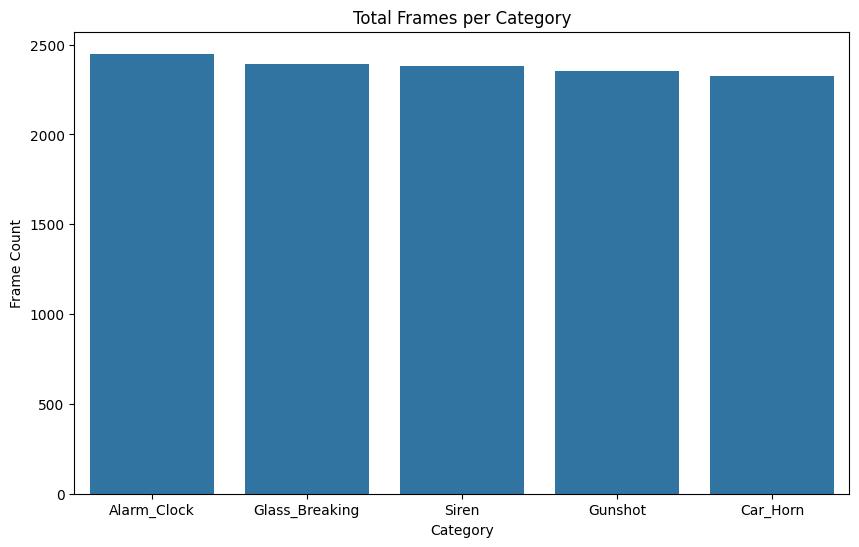

In [18]:
# Class Distribution and Balance
frame_counts = reexp_df.groupby(['category', 'is_augmented']).size().unstack(fill_value=0)
total_counts = reexp_df['category'].value_counts()
print("\nFrame Counts per Category (Original vs Augmented):")
print(frame_counts)
print("\nTotal Frames per Category:")
print(total_counts)
print(f"Total Frames: {len(reexp_df)}")
imbalance_ratio = total_counts.max() / total_counts.min() if total_counts.min() > 0 else float('inf')
print(f"Imbalance Ratio (max/min): {imbalance_ratio:.2f}")
if imbalance_ratio > 2:
    print("Warning: Dataset remains imbalanced; consider further augmentation for underrepresented classes.")

plt.figure(figsize=(10, 6))
sns.barplot(x=total_counts.index, y=total_counts.values)
plt.title('Total Frames per Category')
plt.xlabel('Category')
plt.ylabel('Frame Count')
plt.show()

In [19]:
# Frame Duration
duration_stats = reexp_df.groupby('category')['duration_sec'].agg(['min', 'max', 'mean', 'std'])
print("\nDuration Stats per Category (seconds):")
print(duration_stats)
incorrect_durations = reexp_df[reexp_df['duration_sec'] != FRAME_LENGTH_SEC]
if not incorrect_durations.empty:
    print(f"Warning: {len(incorrect_durations)} frames have incorrect duration:")
    print(incorrect_durations[['frame_path', 'category', 'duration_sec']])


Duration Stats per Category (seconds):
                 min   max  mean  std
category                             
Alarm_Clock     0.96  0.96  0.96  0.0
Car_Horn        0.96  0.96  0.96  0.0
Glass_Breaking  0.96  0.96  0.96  0.0
Gunshot         0.96  0.96  0.96  0.0
Siren           0.96  0.96  0.96  0.0



RMS Stats per Category:
                    mean       std
category                          
Alarm_Clock     0.063230  0.016605
Car_Horn        0.082319  0.019595
Glass_Breaking  0.032867  0.012471
Gunshot         0.082241  0.018988
Siren           0.091876  0.012759


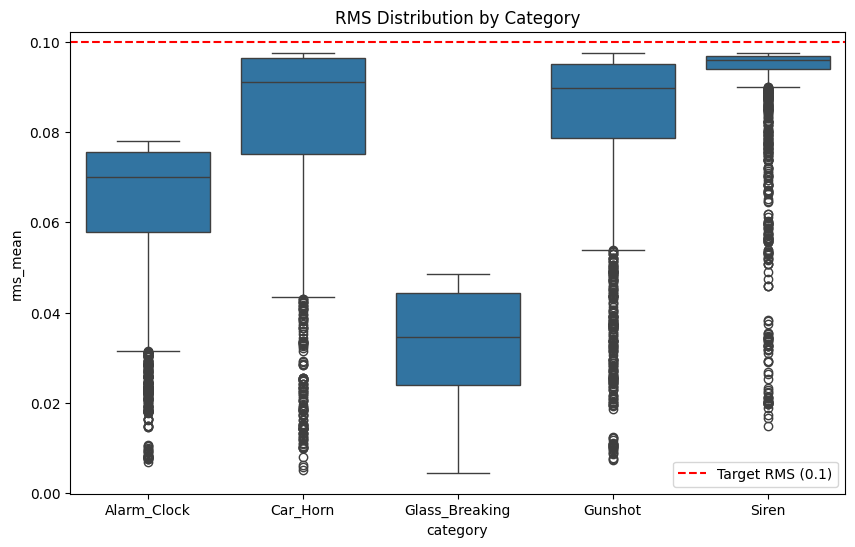

In [20]:
# RMS Consistency
rms_stats = reexp_df.groupby('category')['rms_mean'].agg(['mean', 'std'])
print("\nRMS Stats per Category:")
print(rms_stats)
plt.figure(figsize=(10, 6))
sns.boxplot(data=reexp_df, x='category', y='rms_mean')
plt.axhline(y=TARGET_RMS, color='r', linestyle='--', label=f'Target RMS ({TARGET_RMS})')
plt.title('RMS Distribution by Category')
plt.legend()
plt.show()
if any(rms_stats['std'] > 0.05):
    print("Warning: High RMS variability detected; normalization may need adjustment.")

In [21]:
# SNR Analysis (focus on Siren)
snr_stats = reexp_df.groupby('category')['snr_db'].agg(['mean', 'std'])
print("\nSNR Stats per Category (dB):")
print(snr_stats)
low_snr_siren = reexp_df[(reexp_df['category'] == 'Siren') & (reexp_df['snr_db'] < LOW_SNR_THRESHOLD)]
if not low_snr_siren.empty:
    print(f"Warning: {len(low_snr_siren)} Siren frames have low SNR (<{LOW_SNR_THRESHOLD} dB):")
    print(low_snr_siren[['frame_path', 'snr_db']])


SNR Stats per Category (dB):
                     mean        std
category                            
Alarm_Clock     14.712002  11.310736
Car_Horn        13.369808  11.832743
Glass_Breaking  26.548106  21.043305
Gunshot         11.784766   9.588697
Siren            5.950643   7.120596
                                             frame_path    snr_db
9524   ../data/processed\Siren\-0Eem_FuIto_15_f0_a0.npy  5.179535
9525   ../data/processed\Siren\-0Eem_FuIto_15_f0_a1.npy  2.624671
9526   ../data/processed\Siren\-0Eem_FuIto_15_f0_a2.npy  6.024194
9527   ../data/processed\Siren\-0Eem_FuIto_15_f1_a0.npy  3.955957
9528   ../data/processed\Siren\-0Eem_FuIto_15_f1_a1.npy  2.669564
...                                                 ...       ...
11901  ../data/processed\Siren\ENMIxLDigIQ_60_f2_a1.npy  1.923103
11902  ../data/processed\Siren\ENMIxLDigIQ_60_f2_a2.npy  2.626022
11903  ../data/processed\Siren\ENMIxLDigIQ_60_f3_a0.npy  4.007994
11904  ../data/processed\Siren\ENMIxLDigIQ_60_f3_a1

In [22]:
# Clipping Check
clipped_frames = reexp_df[reexp_df['is_clipped']]
print(f"\nClipped Frames: {len(clipped_frames)}")
if not clipped_frames.empty:
    print("Warning: Clipping detected in processed frames (should be fixed):")
    print(clipped_frames[['frame_path', 'category', 'max_amp']])


Clipped Frames: 0


In [23]:
# Silent/Low-Amplitude Frames
silent_frames = reexp_df[reexp_df['is_silent']]
print(f"\nSilent/Low-Amplitude Frames: {len(silent_frames)}")
if not silent_frames.empty:
    print("Warning: Silent/low-amplitude frames detected (should be excluded):")
    print(silent_frames[['frame_path', 'category', 'rms_mean']])


Silent/Low-Amplitude Frames: 170
                                             frame_path     category  rms_mean
2150  ../data/processed\Alarm_Clock\Mq7QHXMPnpc_0_f0...  Alarm_Clock  0.007795
2151  ../data/processed\Alarm_Clock\Mq7QHXMPnpc_0_f0...  Alarm_Clock  0.008236
2152  ../data/processed\Alarm_Clock\Mq7QHXMPnpc_0_f0...  Alarm_Clock  0.008030
2153  ../data/processed\Alarm_Clock\Mq7QHXMPnpc_0_f0...  Alarm_Clock  0.007901
2154  ../data/processed\Alarm_Clock\Mq7QHXMPnpc_0_f0...  Alarm_Clock  0.008178
...                                                 ...          ...       ...
7895  ../data/processed\Gunshot\3ruqibwoewo_110_f0_a...      Gunshot  0.009686
7896  ../data/processed\Gunshot\3ruqibwoewo_110_f0_a...      Gunshot  0.009974
8240  ../data/processed\Gunshot\5r3fgufqr1I_20_f3_a0...      Gunshot  0.008695
8241  ../data/processed\Gunshot\5r3fgufqr1I_20_f3_a1...      Gunshot  0.008878
8242  ../data/processed\Gunshot\5r3fgufqr1I_20_f3_a2...      Gunshot  0.009132

[170 rows x 3 col

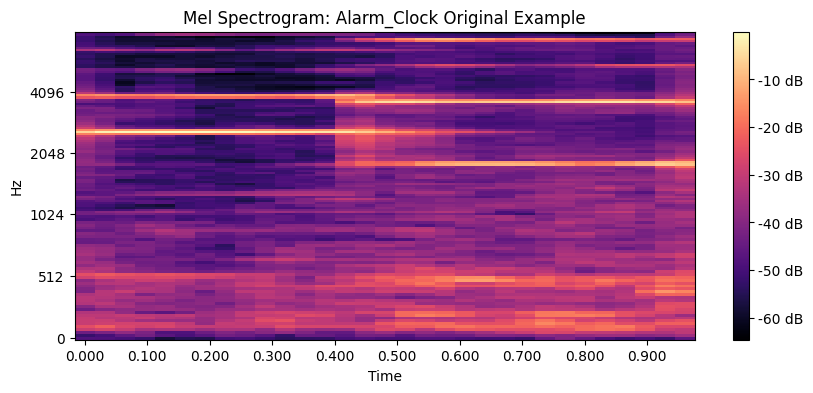

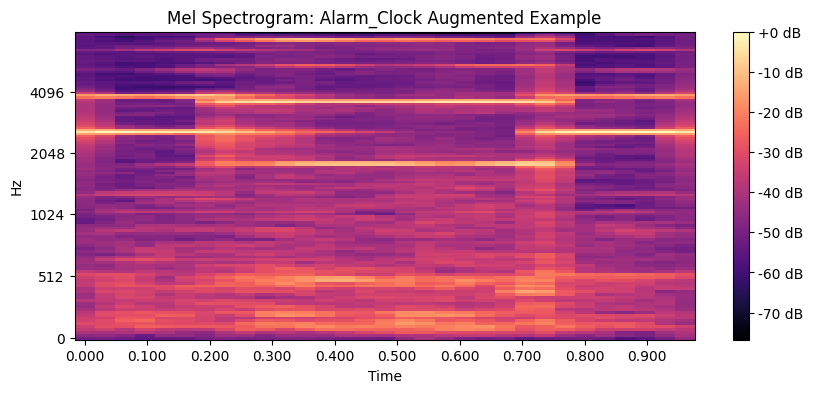

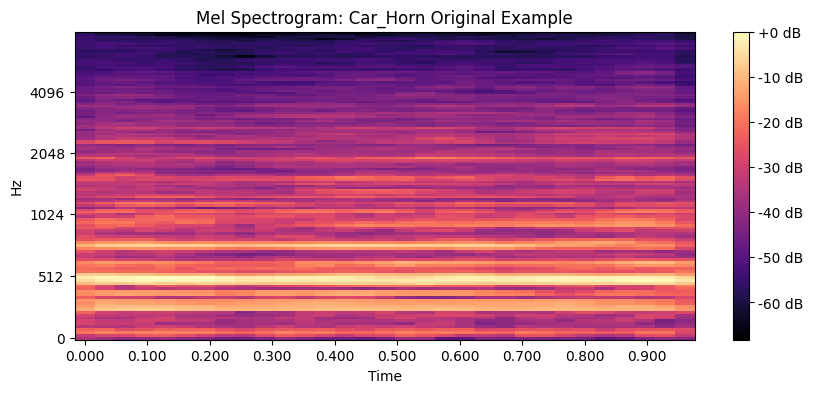

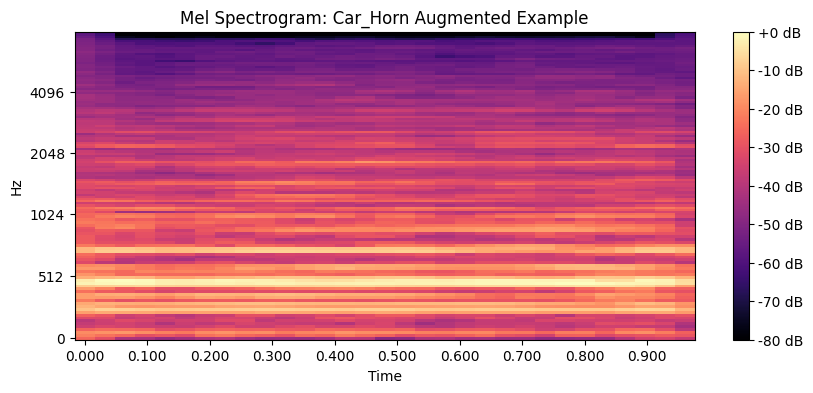

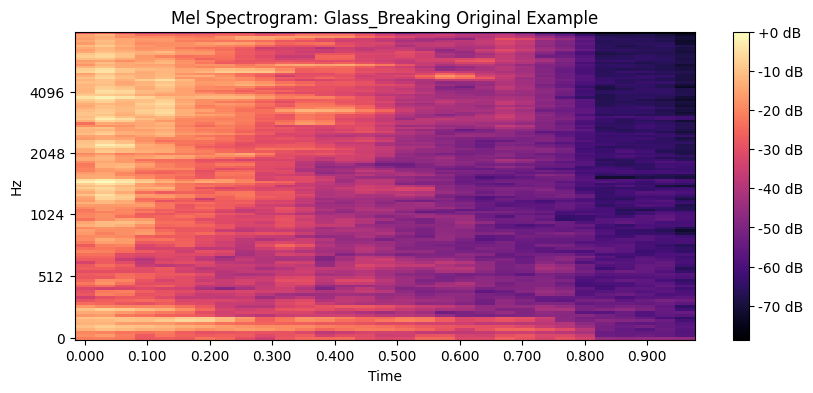

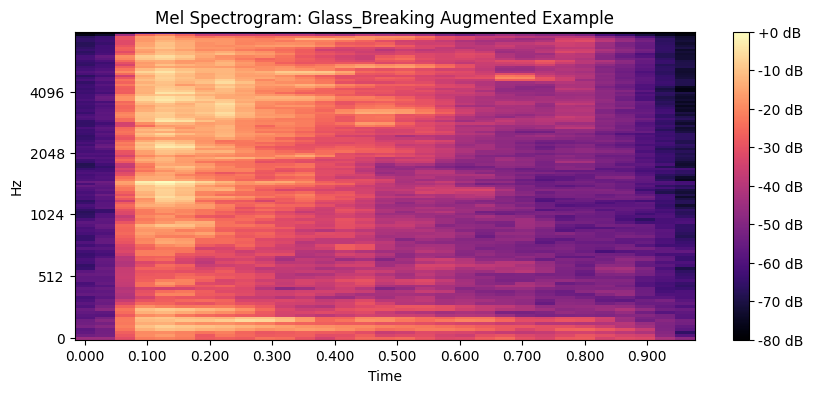

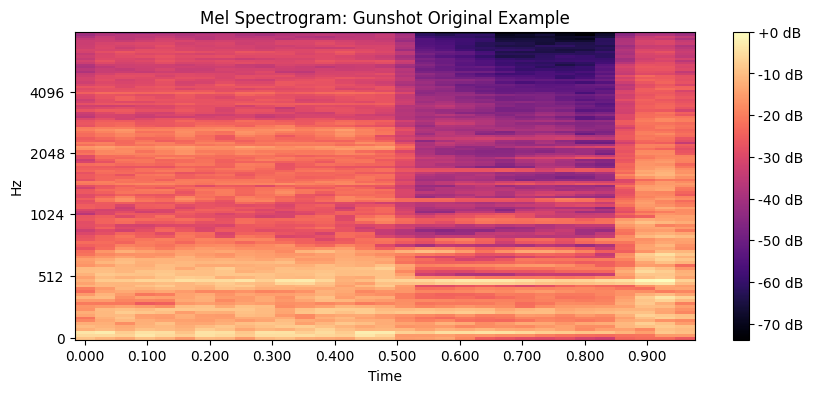

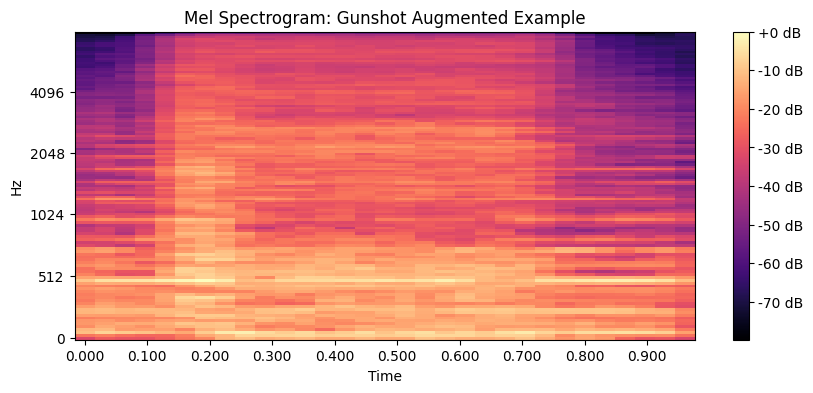

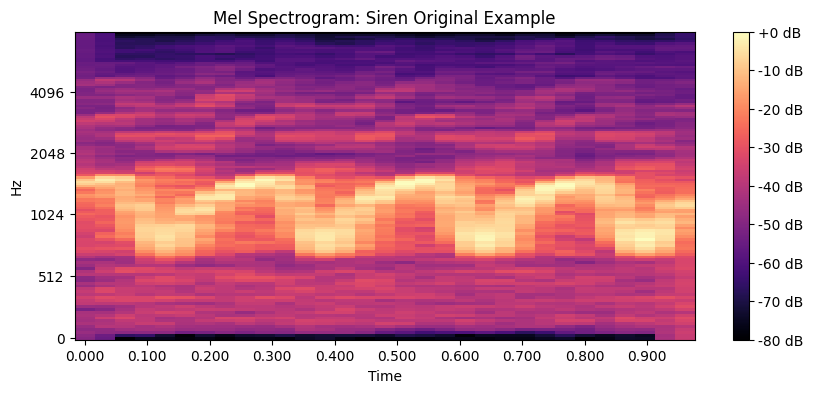

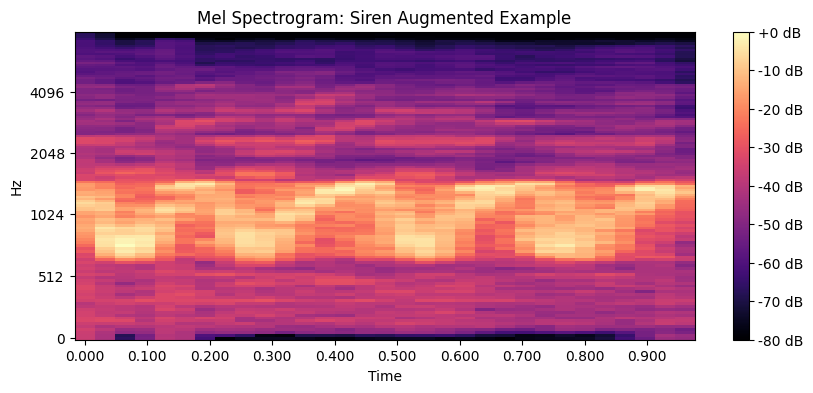

In [24]:
# Spectral Characteristics (sample spectrograms)
for category in categories:
    # Original frame
    orig_df = reexp_df[(reexp_df['category'] == category) & (reexp_df['is_augmented'] == False) & reexp_df['load_success']]
    if not orig_df.empty:
        sample_path = orig_df['frame_path'].iloc[0]
        y = np.load(sample_path)
        plt.figure(figsize=(10, 4))
        S = librosa.feature.melspectrogram(y=y, sr=TARGET_SR, n_mels=128, fmax=8000)
        S_dB = librosa.power_to_db(S, ref=np.max)
        librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=TARGET_SR, fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel Spectrogram: {category} Original Example')
        plt.show()
    
    # Augmented frame (if exists)
    aug_df = reexp_df[(reexp_df['category'] == category) & (reexp_df['is_augmented'] == True) & reexp_df['load_success']]
    if not aug_df.empty:
        sample_path = aug_df['frame_path'].iloc[0]
        y = np.load(sample_path)
        plt.figure(figsize=(10, 4))
        S = librosa.feature.melspectrogram(y=y, sr=TARGET_SR, n_mels=128, fmax=8000)
        S_dB = librosa.power_to_db(S, ref=np.max)
        librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=TARGET_SR, fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel Spectrogram: {category} Augmented Example')
        plt.show()


Augmentation Quality (RMS and ZCR):
                             rms_mean            zcr_mean          
                                 mean       std      mean       std
category       is_augmented                                        
Alarm_Clock    False         0.062956  0.016721  0.318404  0.144394
               True          0.063298  0.016579  0.322380  0.136572
Car_Horn       False         0.081860  0.019965  0.164328  0.076350
               True          0.082548  0.019410  0.166113  0.077258
Glass_Breaking False         0.032327  0.012564  0.296710  0.162722
               True          0.032975  0.012453  0.326907  0.159437
Gunshot        False         0.082069  0.019010  0.160288  0.077401
               True          0.082327  0.018983  0.164990  0.077473
Siren          False         0.091946  0.012868  0.164547  0.057064
               True          0.091841  0.012708  0.165582  0.057425


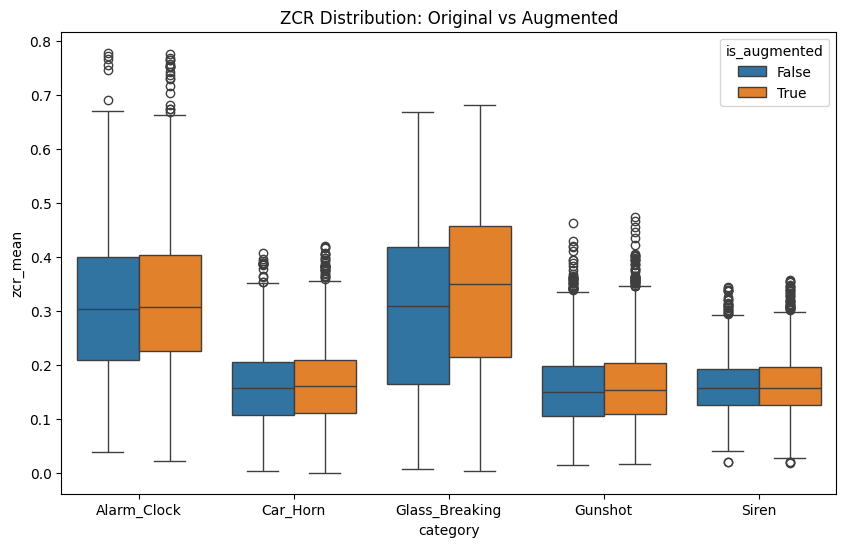

In [25]:
# Augmentation Quality (compare RMS and ZCR)
aug_quality = reexp_df.groupby(['category', 'is_augmented'])[['rms_mean', 'zcr_mean']].agg(['mean', 'std'])
print("\nAugmentation Quality (RMS and ZCR):")
print(aug_quality)
plt.figure(figsize=(10, 6))
sns.boxplot(data=reexp_df, x='category', y='zcr_mean', hue='is_augmented')
plt.title('ZCR Distribution: Original vs Augmented')
plt.show()

In [26]:
# Total Dataset Size
total_size_mb = sum(os.path.getsize(f) for f in glob.glob(os.path.join(data_dir, '**/*.npy'), recursive=True)) / (1024 * 1024)
print(f"\nApproximate Total Disk Size: {total_size_mb:.2f} MB")


Approximate Total Disk Size: 1206.67 MB
